In [203]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import time
import re
def jobname(x):
    match=re.match(r'.*cern.ch/([\w|\d]+)\|NEWMOVER.*',x)
    if match:
        return match.group(1)
    else:
        return x
df_boinc=pd.read_csv("boinc_job.csv")
df_panda=pd.read_csv("panda_job.csv")
df_panda["name"]=df_panda["name"].map(jobname)
dfb=df_boinc.copy()
dfp=df_panda.copy()

df=df_boinc.merge(df_panda,on=["name","host","task"],how="inner")
del df["host"]
del df["name"]
df=df[df["boinc_cputime"]<2000*df["nevents"]]
df=df[df.panda_cpu_eff>0.5]
#df["av"]=df["av"].map(lambda x: "native" if x==478 else "vm")
df["av"]=df.apply(lambda x: "native" if x["av"]==478 else "vm",axis=1)
df["boinc_walltime"]=df["boinc_walltime"]*df["ncore"]
df["boinc_cpu_eff"]=np.round(df["boinc_cputime"]/(df["boinc_walltime"]),2)
print(df.shape) 
df.head()

(212803, 12)


,av,boinc_cputime,boinc_walltime,host_flops,host_ncpu,task,ncore,panda_cputime,panda_walltime,panda_cpu_eff,nevents,boinc_cpu_eff
0,vm,28637.02,70054.412416,4.386782,8,12790254,8,51493,68160,0.76,200,0.41
1,vm,187517.60,188298.390078,2.280070,8,12763289,1,179755,188100,0.96,200,1.00
2,native,250862.00,259147.287440,1.848104,4,12763289,4,250675,258960,0.97,200,0.97
3,native,37227.95,43136.818452,2.176211,4,12790254,4,37182,42960,0.87,200,0.86
4,vm,86352.56,116732.060129,4.957528,8,12763289,1,83314,95280,0.87,200,0.74


['vm' 'native']


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/p

panda_cputime_vm panda_cpu_eff_vm       nevents_vm  \
                       mean             mean count        sum   
walltime                                                        
169.482474     58901.586124         0.907081   418      83600   
184.282779     54743.709815         0.935789   703     140600   
200.433613     74171.753219         0.895408   466      93200   
203.848623     54275.222995         0.907820  4027     805400   
232.256022     58912.812500         0.880670   224      44800   

           panda_cputime_native panda_cpu_eff_native        nevents_native  \
                           mean                 mean  count            sum   
walltime                                                                     
169.482474         66256.296296             0.977407     27           5400   
184.282779         45983.089286             0.968437    224          44800   
200.433613         52675.636364             0.965455     11           2200   
203.848623         57207.667607             0.945412  36511        7302100   
232.256022         51656.855072             0.913478    138          27600   

           cputimeperevent_vm cputimeperevent_native cputime_native  \
                                                                      
walltime                                                              
169.482474         294.507931             331.281481   66256.296296   
184.282779         273.718549             229.915446   45983.089286   
200.433613         370.858766             263.378182   52675.636364   
203.848623         271.376115             286.042255   57207.667607   
232.256022         294.564062             258.284275   51656.855072   

           cpu_eff_vm cpu_eff_native  
                                      
walltime                              
169.482474   0.907081       0.977407  
184.282779   0.935789       0.968437  
200.433613   0.895408       0.965455  
203.848623   0.907820       0.945412  
232.256022   0.880670       0.913478

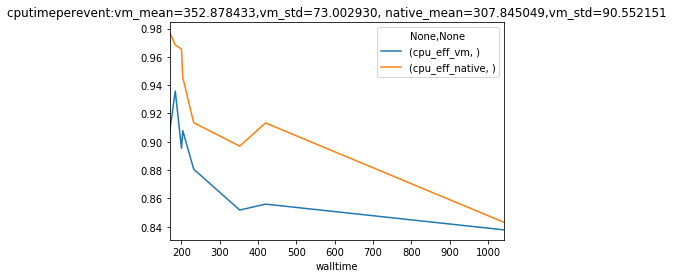

In [209]:
from scipy.stats import norm
print(df.av.unique())
group_task=df.groupby(["av","task","ncore"]).agg({"panda_cpu_eff":["mean","count"],"panda_cputime":["mean"],"nevents":["sum"]})

ncores=group_task.index.get_level_values("ncore").unique().sort_values()
df_vm=group_task.iloc[group_task.index.get_level_values("av")=="vm"]
df_vm.index=df_vm.index.droplevel(0)
df_native=group_task.iloc[group_task.index.get_level_values("av")=="native"]
df_native.index=df_native.index.droplevel(0)
df_merge=df_vm.join(df_native, lsuffix='_vm', rsuffix='_native', how='inner')
df_merge=df_merge[df_merge["panda_cpu_eff_vm","count"]>5]
df_merge=df_merge[df_merge["panda_cpu_eff_native","count"]>5]

tasks=df_merge.index.get_level_values("task").unique().sort_values()
for task in tasks[-2:-1]:
    dft=df_merge.iloc[df_merge.index.get_level_values("task")==task]
    dft.index=dft.index.droplevel(0)
    dft["cputimeperevent_vm"]=dft["panda_cputime_vm","mean"]*dft["panda_cpu_eff_vm","count"]/dft["nevents_vm","sum"]
    dft["cputimeperevent_native"]=dft["panda_cputime_native","mean"]*dft["panda_cpu_eff_native","count"]/dft["nevents_native","sum"]
    dft["walltime"]=(dft["panda_cputime_vm","mean"]+dft["panda_cputime_native","mean"])/(60*2*dft.index.get_level_values("ncore"))
    dft["cputime_native"]=dft["panda_cputime_native","mean"]
    dft["cpu_eff_vm"]=dft["panda_cpu_eff_vm","mean"]
    dft["cpu_eff_native"]=dft["panda_cpu_eff_native","mean"]
    vm_mean,vm_std=norm.fit(dft.cputimeperevent_vm)
    native_mean,native_std=norm.fit(dft.cputimeperevent_native)
    title="cputimeperevent:vm_mean=%f,vm_std=%f, native_mean=%f,vm_std=%f"%(vm_mean,vm_std,native_mean,native_std)
    #dft[["cpu_eff_vm","cpu_eff_native"]].plot(kind="line",title=title)
    dft=dft.set_index("walltime")
    dft.index=dft.index.sort_values()
    #print(dft)
    dft[["cpu_eff_vm","cpu_eff_native"]].plot(kind="line",title=title)
    #dft[["cputimeperevent_native","cputimeperevent_vm"]].plot()
dft.head()


#df1=group_task.iloc[group_task.index.get_level_values("task")==tasks[-1]]
#print(df1)
#group_task.head(10)                 
#df.plot(kind="scatter",x="ncore",y="panda_cputime")

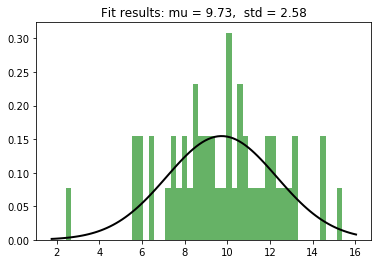

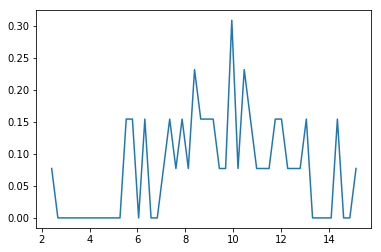

In [205]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=50)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.

count,bins,ignored=plt.hist(data, bins=50, normed=True, alpha=0.6, color='g')
##bins are the numbers of the X axis
##count are the numbers of the Y axis

#plt.hist(data, bins=25, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
#x=bins
p = norm.pdf(x, mu, std)
#print(p)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

plt.plot(bins[0:50],count)

x= [5 2 7 6 9 4 1 3 0 8]
          A         B         C
5  0.372403 -0.700705  1.801561
2  0.522305  0.370008  0.033476
7  0.761026  0.965024 -0.491648
6  0.617008 -0.161319 -1.318991
9  0.013535  0.595480  0.889375
4  0.776817 -0.091329 -0.160011
1  0.850928 -0.952484  0.327845
3  0.924112 -1.952373  1.497779
0 -0.980876  0.722207  0.836762
8 -1.142842  0.327978  1.061688
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


,A,B,C
0,-0.980876,0.722207,0.836762
1,0.850928,-0.952484,0.327845
2,0.522305,0.370008,0.033476
3,0.924112,-1.952373,1.497779
4,0.776817,-0.091329,-0.160011
